## Import Library

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.metrics import mean_absolute_error, make_scorer
from xgboost import XGBRegressor
import os

## Import Data

### Define the path

In [2]:
data_path = os.path.join(os.getcwd(), '..', '..', 'data', 'preprocessed_data.csv')

### Read the csv

In [3]:
df = pd.read_csv(data_path)
df.head()

,property_name,room_id,bedroom,bathroom,beds,guests,wifi,tv,cable_tv,ac,...,beachfront,building_staff,lat,lng,distance_to_coastline,booking_window,stay_duration_in_days,review_sentiment_score,rating,average_daily_rate
0,Bingin Ombak,431874,1,1,1,2,1,0,0,1,...,1,0,-8.805646,115.113378,15.6035,81,4,0.458603,4.0,1.477799e+06
1,Bingin Ombak,431875,1,1,1,2,1,0,0,1,...,1,0,-8.805646,115.113378,15.6035,81,4,0.458603,4.0,1.477799e+06
2,Bingin Ombak,396658,1,1,1,2,1,0,0,1,...,1,0,-8.805646,115.113378,15.6035,81,4,0.458603,4.0,1.477799e+06
3,Bingin Ombak,396427,1,2,1,2,1,0,0,0,...,1,0,-8.805646,115.113378,15.6035,81,4,0.455450,4.0,1.477799e+06
4,Bingin Ombak,396427,1,2,1,2,1,0,0,0,...,1,0,-8.805646,115.113378,15.6035,81,4,0.455450,4.0,1.477799e+06


### Separate features and target variable

In [4]:
X = df.drop(columns=['property_name', 'room_id', 'average_daily_rate'])
y = df['average_daily_rate']

### Split the normalized data into training and testing sets

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Create XGBoost Model

In [6]:
# Initialize the XGBoost model
model = XGBRegressor()

# Fit the model on the training data
model.fit(X_train, y_train)

# Make predictions on the test data
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# Evaluate the model
training_mae = mean_absolute_error(y_train, y_pred_train)
print(f'Mean Absolute Error on Training: {training_mae}')

testing_mae = mean_absolute_error(y_test, y_pred_test)
print(f'Mean Absolute Error on Testing: {testing_mae}')

Mean Absolute Error on Training: 64058.21754531989
Mean Absolute Error on Testing: 69728.52979346873


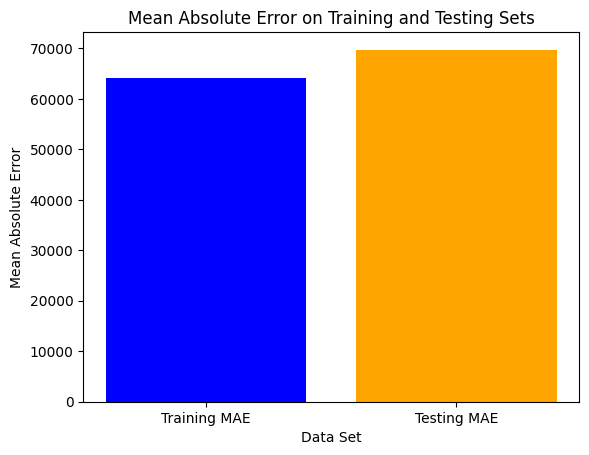

In [7]:
# Plotting the MAE
mae_values = [training_mae, testing_mae]
labels = ['Training MAE', 'Testing MAE']

plt.bar(labels, mae_values, color=['blue', 'orange'])
plt.xlabel('Data Set')
plt.ylabel('Mean Absolute Error')
plt.title('Mean Absolute Error on Training and Testing Sets')
plt.show()

### Tuned The Hyperparameter

In [8]:
# Define the model
tuned_model = XGBRegressor(random_state=42)

# Define the parameter grid
param_grid = {
    'n_estimators': [500, 1000, 2000],
    'learning_rate': [0.3, 0.4, 0.5],
    'max_depth': [9, 10, 11]
}

# Set up the Grid Search
grid_search = GridSearchCV(estimator=tuned_model, 
                           param_grid=param_grid, 
                           scoring='neg_mean_absolute_error', 
                           cv=5, 
                           verbose=2, 
                           n_jobs=-1)

# Fit the Grid Search
grid_search.fit(X_train, y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f'Best Parameters: {best_params}')
print(f'Best Mean Absolute Error: {-best_score}')


Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV] END ...learning_rate=0.3, max_depth=9, n_estimators=500; total time=  20.3s
[CV] END ...learning_rate=0.3, max_depth=9, n_estimators=500; total time=  20.4s
[CV] END ...learning_rate=0.3, max_depth=9, n_estimators=500; total time=  20.5s
[CV] END ...learning_rate=0.3, max_depth=9, n_estimators=500; total time=  20.7s
[CV] END ...learning_rate=0.3, max_depth=9, n_estimators=500; total time=  23.8s
[CV] END ..learning_rate=0.3, max_depth=9, n_estimators=1000; total time=  46.5s
[CV] END ..learning_rate=0.3, max_depth=9, n_estimators=1000; total time=  46.6s
[CV] END ..learning_rate=0.3, max_depth=9, n_estimators=1000; total time=  46.7s
[CV] END ..learning_rate=0.3, max_depth=9, n_estimators=1000; total time=  38.6s
[CV] END ..learning_rate=0.3, max_depth=9, n_estimators=1000; total time=  32.0s
[CV] END ..learning_rate=0.3, max_depth=9, n_estimators=2000; total time= 1.1min
[CV] END ..learning_rate=0.3, max_depth=9, n_es

### Cross Validation

In [9]:
# Define your XGBoost model
model = XGBRegressor(learning_rate=0.3, max_depth=9, n_estimators=2000, random_state=42)

# Define the k-fold cross-validation scheme
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Define the scoring function
scorer = make_scorer(mean_absolute_error, greater_is_better=False)

# Perform cross-validation and get scores
cv_scores = cross_val_score(model, X_train, y_train, cv=kf, scoring=scorer)

# Convert negative MAE to positive since we used greater_is_better=False
cv_scores = -cv_scores

# Print the cross-validation scores and their mean
print(f'Cross-Validation MAE Scores: {cv_scores}')
print(f'Mean Cross-Validation MAE: {np.mean(cv_scores)}')

# Fit the model on the entire training data
model.fit(X_train, y_train)

# Make predictions on the test data
y_pred_test = model.predict(X_test)

# Evaluate the model on the test data
testing_mae = mean_absolute_error(y_test, y_pred_test)
print(f'Mean Absolute Error on Testing: {testing_mae}')

Cross-Validation MAE Scores: [23462.96771148 22764.58453413 23411.88136619 22824.93764612
 22979.66017118]
Mean Cross-Validation MAE: 23088.806285819057
Mean Absolute Error on Testing: 20083.707416781002


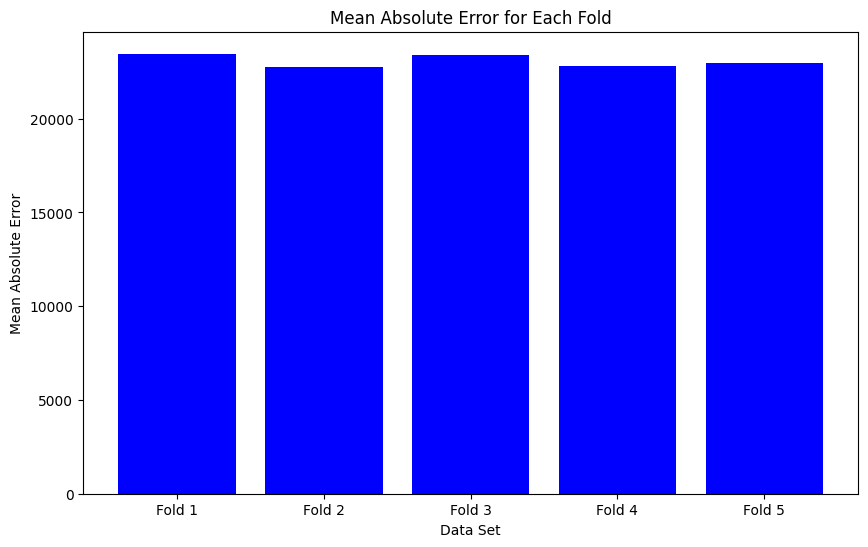

In [13]:
# Plotting the MAE for each fold and the test set
fold_labels = [f'Fold {i+1}' for i in range(len(cv_scores))]

mae_values = list(cv_scores)

plt.figure(figsize=(10, 6))
plt.bar(fold_labels, mae_values, color=['blue']*len(cv_scores))
plt.xlabel('Data Set')
plt.ylabel('Mean Absolute Error')
plt.title('Mean Absolute Error for Each Fold')
plt.show()

## Train With Best Parameter

In [14]:
# Initialize the XGBoost model
model = XGBRegressor(learning_rate=0.3, max_depth=9, n_estimators=2000, random_state=42)

# Fit the model on the training data
model.fit(X_train, y_train)

# Make predictions on the test data
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# Evaluate the model
training_mae = mean_absolute_error(y_train, y_pred_train)
print(f'Mean Absolute Error on Training: {training_mae}')

testing_mae = mean_absolute_error(y_test, y_pred_test)
print(f'Mean Absolute Error on Testing: {testing_mae}')

Mean Absolute Error on Training: 9553.380899508991
Mean Absolute Error on Testing: 20083.707416781002


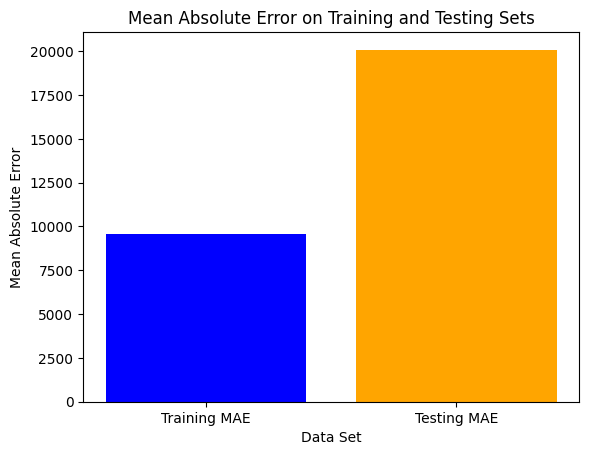

In [15]:
# Plotting the MAE
mae_values = [training_mae, testing_mae]
labels = ['Training MAE', 'Testing MAE']

plt.bar(labels, mae_values, color=['blue', 'orange'])
plt.xlabel('Data Set')
plt.ylabel('Mean Absolute Error')
plt.title('Mean Absolute Error on Training and Testing Sets')
plt.show()

### Feature Important

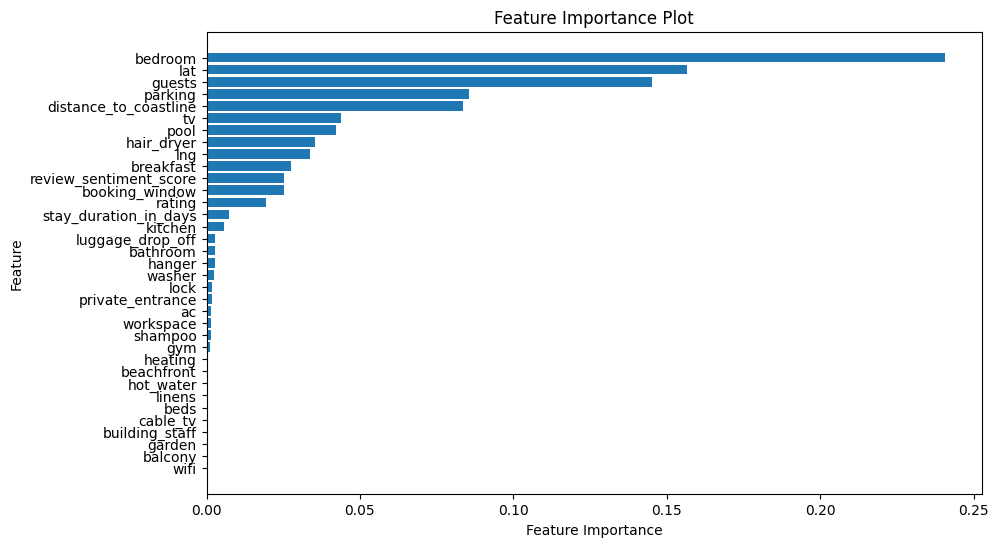

Mean Absolute Error: 20090.440551859603


In [10]:
import matplotlib.pyplot as plt

# Initialize a new XGBoost model with the best hyperparameters
best_model = XGBRegressor(learning_rate=0.3, max_depth=9, n_estimators=2000, random_state=42)

# Train the model on the entire training dataset with the best hyperparameters
best_model.fit(X_train, y_train)

# Get feature importances from the best model
feature_importances = best_model.feature_importances_

# Create a DataFrame to store feature importances with corresponding column names
fi_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})

# Sort the DataFrame by feature importance values
fi_df = fi_df.sort_values(by='Importance', ascending=True)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(fi_df['Feature'], fi_df['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance Plot')
plt.show()

# Make predictions on the test set using the best model
y_pred = best_model.predict(X_test)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error:", mae)

### Predict with Feature Important 

In [16]:
important_column = ['bedroom', 'lat', 'guests',
                    'parking', 'distance_to_coastline',
                    'tv', 'pool', 'hair_dryer', 'lng',
                    'breakfast',
                    'review_sentiment_score',
                    'booking_window',
                    'rating', 'stay_duration_in_days',
                    'kitchen']

X_important = df[important_column]
y_important = df['average_daily_rate']

In [17]:
X_important_train, X_important_test, y_important_train, y_important_test = train_test_split(X_important, y_important, test_size=0.2, random_state=42)

In [18]:
# Initialize the XGBoost model
model = XGBRegressor(learning_rate=0.3, max_depth=9, n_estimators=2000, random_state=42)

# Fit the model on the training data
model.fit(X_important_train, y_important_train)

# Make predictions on the test data
y_pred_important_train = model.predict(X_important_train)
y_pred_important_test = model.predict(X_important_test)

# Evaluate the model
training_important_mae = mean_absolute_error(y_important_train, y_pred_important_train)
print(f'Mean Absolute Error on Training: {training_important_mae}')

testing_important_mae = mean_absolute_error(y_important_test, y_pred_important_test)
print(f'Mean Absolute Error on Testing: {testing_important_mae}')

Mean Absolute Error on Training: 9800.13064658113
Mean Absolute Error on Testing: 17305.73649814014


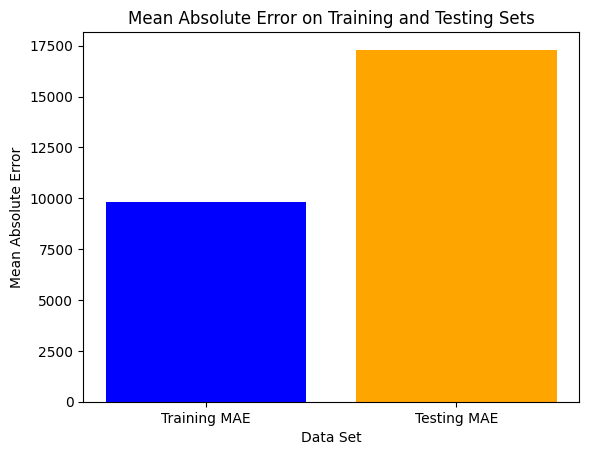

In [20]:
# Plotting the MAE
mae_values = [training_important_mae, testing_important_mae]
labels = ['Training MAE', 'Testing MAE']

plt.bar(labels, mae_values, color=['blue', 'orange'])
plt.xlabel('Data Set')
plt.ylabel('Mean Absolute Error')
plt.title('Mean Absolute Error on Training and Testing Sets')
plt.show()

### Convert Model to PKL

In [16]:
import joblib

# Save the trained model to a file
joblib.dump(model, 'xgboost_model.pkl')

['xgboost_model.pkl']

### Load and test the model

In [17]:
# Load the trained XGBoost model
xgboost_model = joblib.load('xgboost_model.pkl')

# Use XGBoost model to make predictions
xgboost_predictions_test = xgboost_model.predict(X_important_test)

# Now you can use these predictions in your TensorFlow code
print("Predictions:", xgboost_predictions_test[:10])
print("Actual Prices:", y_important_test[:10])

Predictions: [462077.38 540067.44 360076.78 643797.9  506753.16 559206.6  395427.34
 440055.06 620085.25 620129.7 ]
Actual Prices: 21095    462077.400000
33631    540067.500000
29589    360076.333333
34856    655632.846154
49493    506752.666667
28452    559206.592593
28509    450049.400000
24414    440055.000000
45005    620083.500000
47107    620130.000000
Name: average_daily_rate, dtype: float64


## Data Pipeline for Prediction

In [18]:
predicted_column = ['property_name', 'room_id', 
                    'bedroom', 'lat', 'guests',
                    'parking', 'distance_to_coastline',
                    'tv', 'pool', 'hair_dryer', 'lng',
                    'breakfast',
                    'review_sentiment_score',
                    'booking_window',
                    'rating',
                    'stay_duration_in_days', 'kitchen',
                    'average_daily_rate']

X_predicted = df[predicted_column]

### Drop Duplicated Data

In [14]:
distinct_data = X_predicted.drop_duplicates(subset=['property_name', 'room_id'])

### Save Distinct Data

In [16]:
distinct_data.to_csv('xgboost_distinct_data.csv', index=False)

### Test with New Data

In [22]:
import pandas as pd
from datetime import date
import joblib


def booking_window(today, check_in):
    return (check_in - today).days

def stay_duration(check_in, check_out):
    return (check_out - check_in).days

def predict(predicted_df, property_name, room_id, check_in, check_out):
    # Select property name and room_id
    filtered_df = predicted_df[(predicted_df['property_name'] == property_name) & 
                              (predicted_df['room_id'] == room_id)].copy()
    
    if filtered_df.empty:
        raise ValueError("No matching property_name and room_id found in the data")
    
    # Save the current price
    current_price = filtered_df['average_daily_rate'].values
    
    # Drop unnecessary columns
    filtered_df.drop(columns=['property_name', 'room_id', 'average_daily_rate'], inplace=True)
    
    # Feature engineering booking window
    today = date.today()
    booking_window_days = booking_window(today, check_in)
    
    # Feature engineering stay duration
    stay_duration_days = stay_duration(check_in, check_out)
    
    # Replace values in columns
    filtered_df['stay_duration_in_days'] = stay_duration_days
    filtered_df['booking_window'] = booking_window_days
    
    # print("Filtered DataFrame after replacing values:\n", filtered_df)
    print("Booking window (days):", booking_window_days)
    print("Stay duration (days):", stay_duration_days)
    
    # Predict
    # xgboost_model = joblib.load('xgboost_model.pkl')
    xgboost_model = joblib.load(os.path.join(os.getcwd(), '..', '..', 'data', 'xgboost_model.pkl'))
    xgboost_predictions_test = xgboost_model.predict(filtered_df)
    
    return xgboost_predictions_test, current_price

def format_currency(value):
    value_str = f"{value:,.2f}"
    value_str = value_str.replace(',', 'X').replace('.', ',').replace('X', '.')
    return f"Rp {value_str}"

# Example usage
check_in = date(2024, 12, 24)
check_out = date(2024, 12, 25)

prediction, current_price = predict(distinct_data, 'Amazon Guesthouse', 397693, check_in, check_out)
formatted_current_price = format_currency(current_price[0])
formatted_prediction = format_currency(prediction[0])

print("Current Price:", formatted_current_price)
print("Prediction:", formatted_prediction)

Booking window (days): 201
Stay duration (days): 1
Current Price: Rp 446.768,58
Prediction: Rp 553.790,56
